In [1]:
import pandas as pd
import yaml
import pickle
import os
import logging
from utilities.utilities import *
from utilities.plotting import plot_exposure_map, plot_exposure_contour, plot_gdp_increase_map, plot_gdp_increase_scatter
from utilities.plotting import plot_variable_map, plot_cdd_scatter

In [2]:
# Load configuration from config.yaml
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
logging.basicConfig(level=config['logging_level'])

with open('exposure_function_params_{0}.pkl'.format(config['availability_function']), 'rb') as f:
    params = pickle.load(f)

if config['availability_function'] == 'power_law':
    avail_func = power_avail
elif config['availability_function'] == 'exponential':
    avail_func = exp_avail
else:
    raise ValueError('Availability function not recognized')

def exposure_new(cdd, gdp):
    return exposure_function((cdd, gdp), avail_func, params['cdd_scale'], params['alpha'], params['k'])

ref_year = config['analysis_years']['ref_year']
past_year = config['analysis_years']['past_year']
future_year = config['analysis_years']['future_year']

outfile_path = config['output_path']

In [3]:
# Collect country-level data, only recalculate if the file does not exist

if os.path.exists(outfile_path):
    logging.info('Reading in experienced temperature data from file {}'.format(outfile_path))
    # Read in the data
    ac_data = pd.read_csv(outfile_path)

else:
    logging.info('Heat exposure analysis results not found, recalculating')

    # Read the historical cooling degree days data
    cdd_data = read_cdd_data(config['cdd_historical_file'])
    ac_data_historical = cdd_data[cdd_data['Year'] == ref_year].drop(columns=['Year'])

    # Read the historical GDP data
    gdp_data = read_gdp_data(config['gdp_historical_file'])
    for year in [past_year, ref_year]:
        gdp_data_year = gdp_data[gdp_data['Year'] == year].drop(columns=['Year'])
        fill_missing_country_gdp_data(year, gdp_data_year, config)
        if year == past_year:
            gdp_data_year = gdp_data_year.rename(columns={'GDP': 'GDP_past'})
        ac_data_historical = pd.merge(ac_data_historical, gdp_data_year, on='ISO3', how='outer')

    # Add historical annual GDP growth
    ac_data_historical['gdp_historical_growth'] = calculate_average_gdp_growth(ac_data_historical['GDP'], 
                                            ac_data_historical['GDP_past'], ref_year - past_year)
    # Add predictions for CDD in 2100 in different scenarios
    cdd_projections = read_projections(config, 'cdd', ac_data_historical)

    # Combine historical and projections into one dataframe
    ac_data = pd.merge(ac_data_historical, cdd_projections, on='ISO3', how='outer')
    ac_data = ac_data.dropna()
    ac_data.reset_index(drop=True, inplace=True)

    # Add column for historical heat exposure
    ac_data['exposure_times_cdd'] = exposure_new(ac_data['CDD'], ac_data['GDP'], avail_func, params)*ac_data['CDD']

    # Sort by income quantile and label each country with income group
    ac_data['income_group'] = pd.qcut(ac_data['GDP'], 5, labels=config['income_groups'])
    
    # Calculate GDP needed to keep heat exposure constant
    ac_data = calculate_gdp_const(ac_data, config, params)

    # Write full dataframe to csv
    if not os.path.exists(outfile_path):
        ac_data.to_csv(outfile_path)


In [4]:
# Get income group averages of CDD and GDP
ac_data_income_group = ac_data.drop(columns=['ISO3', 'Country'])
ac_data_income_group = ac_data_income_group.groupby('income_group').mean()
# Add row for global average
ac_data_income_group.loc['global average'] = ac_data_income_group.mean()

# Calculate GDP needed to keep exposure times CDD constant
for scenario in config['future_scenarios']:
    # For both countries and income groups
    for df in [ac_data, ac_data_income_group]:
        gdp_const = gdp_from_cdd_exposure(df['exposure_times_cdd'], df['CDD_{0}_{1}'.format(scenario, future_year)],
                                            params, config['availability_function'])
        df['gdp_const_{}'.format(scenario)] = calculate_average_gdp_growth(gdp_const, df['GDP'], future_year - ref_year)

# Recalculate exposure times CDD for income groups
ac_data_income_group['exposure_times_cdd'] = exposure_new(ac_data_income_group['CDD'], ac_data_income_group['GDP'])*ac_data_income_group['CDD']

/home/awongel/miniconda3/envs/experiencedT_env/lib/python3.10/site-packages/matplotlib/text.py:1419: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
/home/awongel/miniconda3/envs/experiencedT_env/lib/python3.10/site-packages/matplotlib/text.py:1421: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
/home/awongel/miniconda3/envs/experiencedT_env/lib/python3.10/site-packages/matplotlib/text.py:830: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/home/awongel/miniconda3/envs/experiencedT_env/lib/python3.10/site-packages/matplotlib/text.py:831: FutureWarning: Calling float on a single element Series

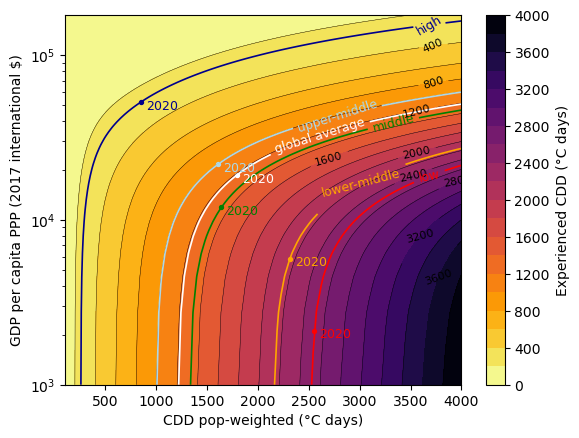

In [5]:
# Make all plots

for scenario in ['historical'] + config['future_scenarios']:

    # Parts of Figure 2
    # plot_gdp_increase_map(config, ac_data, scenario, exposure_new)

    # Parts of Figure 1 and 3
    if scenario == 'historical':
        scen = ''
    else:
        scen = '_'+scenario+'_2100'
    # plot_variable_map(config, ac_data, 'CDD'+scen)

    if scenario == 'historical':
        # Part of Figure 1
        # plot_variable_map(config, ac_data, 'GDP')
        continue
    
    # Part of Figure 1
    # Plot exposure contour for absoulte CDD and GDP
    # plot_exposure_contour(config, exposure_new, ac_data_income_group, x_y_ranges=[[100, 4000, 100],[1000, 175000, 100]], 
    #                   name_tag='exposure_contour', scenario=scenario)

    # Part of Figure 2
    # plot_gdp_increase_scatter(config, ac_data, scenario)

    # Part of Figure 3
    # plot_cdd_scatter(config, ac_data, scenario)

# Figure 3
# Plot contour for each income group with x and y percent increase in CDD and GDP
# x_max = [4.5, 3., 2., 1.25, 0.25, 1.5]
# for i, income_group in enumerate(config['income_groups_colors'].keys()):
#     if income_group == 'high':
#         neg_cdd = 10
#         neg_gdp = 0.2
#     else:
#         neg_cdd = 0.
#         neg_gdp = 0.
#     plot_exposure_contour(config, exposure_new, ac_data_income_group, x_y_ranges=[[0-neg_cdd, 60, 100],[0-neg_gdp, x_max[i], 100]],
#                     country=income_group, name_tag='exposure_contour_{}'.format(income_group))


    
